# Project : Exploring the UK's rice imports and exports

by Aya Tamura, 25 November, 2023

As an Asian living in the United Kingdom, I often eat rice and appreciate the availability of variety of rice in shops. According to [the Rice Association]('https://www.riceassociation.org.uk/rice-in-the-uk'), rice is not grown in the UK. I wonder where rice comes from to the UK. Is rice cultivated domestically within the UK, or is it solely imported from abroad? In this project, I aim to conduct research on the locales where rice comes from using available data.

# Getting Data

The United Nations (UN) Comtrade database have wide range of global trade data. It shall be leveraged to analyze the UK's rice imports and exports:

- What quantities of rice does the UK export and import, and does a positive balance exist (exports surpassing imports)?
- Which countries constitute the primary trading partners, i.e. from which nations does the UK import most rice, and to which countries are the greatest exports bound?
- Which countries reliably purchase rice from the UK on a monthly basis - the consistent clients?
- Regarding rice, which countries does the UK both import from and export to?

I aim to conduct a judicious study of the UK rice trade sector utilizing UN Comtrade in 2022.
The data is obtained from the [United Nations Comtrade](http://comtrade.un.org/data/) website, by selecting the following configuration:

- Type of Product: goods
- Frequency: Monthly 
- Periods: All of 2022
- Reporter: United Kingdom
- Partners: All
- Flows: imports and exports
- HS (as reported) commodity codes: 100610, 100620, 100630, 100640

In [729]:
# Importing the libraries 
import pandas as pd
import matplotlib.pyplot as plt

In [730]:
# Assign a file location of the CSV data
LOCATION = 'comtrade_rice_monthly_22.csv'

The downloaded file is saved using a file encoding (*Latin-1*). As Pandas does not recognise this by default, resulting in `UnicodeDecodeError`.　Hence, reading a file with `encoding = "Latin-1"` should fix the problem.

In [731]:
# Read the CSV data with latin-1 encoding and diaplay
rice = pd.read_csv(LOCATION, encoding='latin-1')
rice.head(3)

,TypeCode,FreqCode,RefPeriodId,RefYear,RefMonth,Period,ReporterCode,ReporterISO,ReporterDesc,FlowCode,...,IsNetWgtEstimated,GrossWgt,IsGrossWgtEstimated,Cifvalue,Fobvalue,PrimaryValue,LegacyEstimationFlag,IsReported,IsAggregate,Unnamed: 47
0,C,M,20220101,2022,1,202201,826,GBR,United Kingdom,M,...,False,0,False,44525.184,NaN,44525.184,0,False,True,NaN
1,C,M,20220101,2022,1,202201,826,GBR,United Kingdom,M,...,False,0,False,8479.117,NaN,8479.117,0,False,True,NaN
2,C,M,20220101,2022,1,202201,826,GBR,United Kingdom,M,...,False,0,False,2400.542,NaN,2400.542,0,False,True,NaN


In [732]:
rice.tail(3)

,TypeCode,FreqCode,RefPeriodId,RefYear,RefMonth,Period,ReporterCode,ReporterISO,ReporterDesc,FlowCode,...,IsNetWgtEstimated,GrossWgt,IsGrossWgtEstimated,Cifvalue,Fobvalue,PrimaryValue,LegacyEstimationFlag,IsReported,IsAggregate,Unnamed: 47
1549,C,M,20221201,2022,12,202212,826,GBR,United Kingdom,X,...,False,0,False,NaN,864.276,864.276,0,False,True,NaN
1550,C,M,20221201,2022,12,202212,826,GBR,United Kingdom,X,...,False,0,False,NaN,33998.535,33998.535,0,False,True,NaN
1551,C,M,20221201,2022,12,202212,826,GBR,United Kingdom,X,...,False,0,False,NaN,290.534,290.534,0,False,True,NaN


The data covers the whole 12 months of 2022.

In [733]:
# Check column names in the dataframe
rice.columns

Index(['TypeCode', 'FreqCode', 'RefPeriodId', 'RefYear', 'RefMonth', 'Period',
       'ReporterCode', 'ReporterISO', 'ReporterDesc', 'FlowCode', 'FlowDesc',
       'PartnerCode', 'PartnerISO', 'PartnerDesc', 'Partner2Code',
       'Partner2ISO', 'Partner2Desc', 'ClassificationCode',
       'ClassificationSearchCode', 'IsOriginalClassification', 'CmdCode',
       'CmdDesc', 'AggrLevel', 'IsLeaf', 'CustomsCode', 'CustomsDesc',
       'MosCode', 'MotCode', 'MotDesc', 'QtyUnitCode', 'QtyUnitAbbr', 'Qty',
       'IsQtyEstimated', 'AltQtyUnitCode', 'AltQtyUnitAbbr', 'AtlQty',
       'IsAltQtyEstimated', 'NetWgt', 'IsNetWgtEstimated', 'GrossWgt',
       'IsGrossWgtEstimated', 'Cifvalue', 'Fobvalue', 'PrimaryValue',
       'LegacyEstimationFlag', 'IsReported', 'IsAggregate', 'Unnamed: 47'],
      dtype='object')

In [734]:
# Compute the frequency count of unique values in the 'CmdDesc'
rice.value_counts('CmdDesc')

CmdDesc
Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed    748
Cereals; husked (brown) rice                                                      382
Cereals; rice, broken                                                             294
Cereals; rice in the husk (paddy or rough)                                        128
Name: count, dtype: int64

Drop columns that are irrelevant for this analysis. Also, the commodity code is transformed into a short but descriptive text.

In [735]:
# Define a function that takes a code as input and returns a corresponding rice type
def riceType(code):
    if code == 100610: # Cereals; rice in the husk (paddy or rough)
        return 'rough' 
    if code == 100620: # Cereals; husked (brown) rice
        return 'brown'
    if code == 100630: # Cereals; rice, semi-milled or wholly milled, whether or not polished or glazed
        return 'milled'
    if code == 100640: # Cereals; rice, broken
        return 'broken'
    return 'unknown'

COMMODITY = 'RiceType'
rice[COMMODITY] = rice['CmdCode'].apply(riceType)
MONTH = 'Period'
PARTNER = 'PartnerDesc'
FLOW = 'FlowDesc'
VALUE = 'PrimaryValue'

# Selecting columns
headings = [MONTH, PARTNER, FLOW, COMMODITY, VALUE]
rice = rice[headings]
rice.head(3)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
0,202201,World,Import,rough,44525.184
1,202201,Bangladesh,Import,rough,8479.117
2,202201,Iran,Import,rough,2400.542


The data contains the total imports and exports per month, under the 'World' partner. Those rows are removed to keep only the per-country data.

In [736]:
# Removing irrelevant data
rice = rice[rice[PARTNER] != 'World']
rice.head(3)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
1,202201,Bangladesh,Import,rough,8479.117
2,202201,Iran,Import,rough,2400.542
3,202201,Ireland,Import,rough,32479.122


## Total trade flow

To answer the first question, 'How much does the UK export and import and is the balance positive (more exports than imports)?',
the dataframe is split into two groups: exports from the UK and imports into the UK. The  trade values within each group are summed up to get the total trading.

In [737]:
# Rounds the given value to the nearest thousand
def roundToThousands (value):
    return round(value / 1000)

In [738]:
# Group the data by FLOW (import or export) and aggregate the values
grouped = rice.groupby([FLOW])
grouped[VALUE].aggregate(sum).apply(roundToThousands)

FlowDesc
Export     56988
Import    604831
Name: PrimaryValue, dtype: int64

<Axes: ylabel='FlowDesc'>

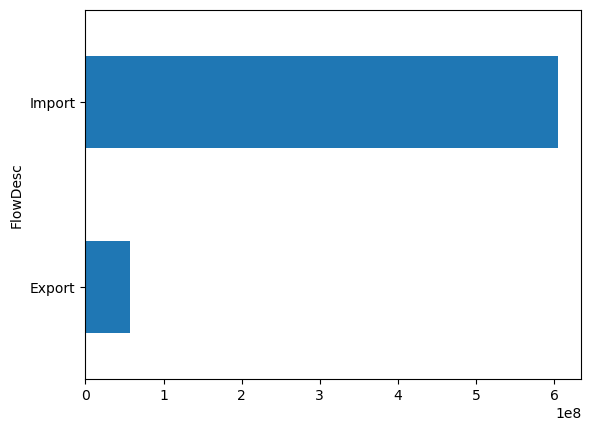

In [739]:
# Plot the aggregated values 
grouped[VALUE].aggregate(sum).plot(kind='barh')

<Axes: ylabel='FlowDesc,RiceType'>

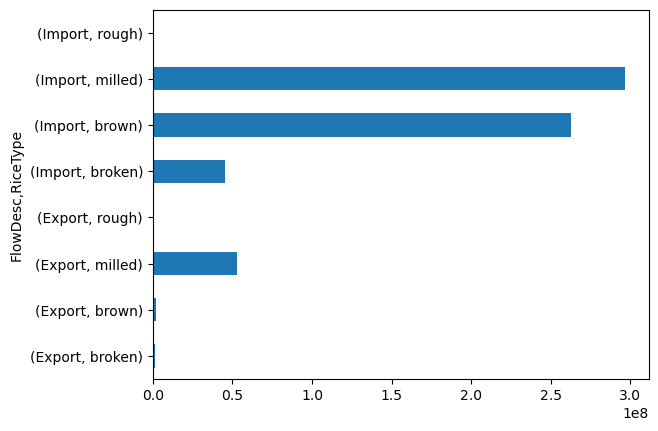

In [740]:
# Group the data by rice type as well as trade flow and plot the aggregate values
riceType = rice.groupby([FLOW, COMMODITY])
riceType[VALUE].aggregate(sum).plot(kind='barh')

The above bar charts show that imports exceed exports, indicating the UK has a rice trade deficit, with its trade balance being negative by approximately 550 thousand US dollars ( 604831-56988). 

Among imported rice, milled and brown rice make up the majority, but only milled rice comprises the majority of exports.

## Main trade partners

To address the second question, 'Which are the main trading partners, i.e. from/to which countries does the UK import/export the most?', the dataframe is split by country instead, and then each group aggregated for the total trade value. This is done separately for imports and exports. The result is sorted in descending order so that the main partners are at the top.

In [741]:
# Create a new dataframe 'imports'
imports = rice[rice[FLOW] == 'Import']
# Group the 'imports' dataframe by the 'PARTNER' column
grouped = imports.groupby([PARTNER])
print('The UK imports from', len(grouped), 'countries.')
print('The 5 biggest exporters to the UK are:')
# Calculate the total imports from each country, sort them in descending order, and round the values to thousands
totalImports = grouped[VALUE].aggregate(sum).sort_values(ascending=False).apply(roundToThousands)
totalImports.head(10)

The UK imports from 55 countries.
The 5 biggest exporters to the UK are:


PartnerDesc
India        161635
Pakistan     100425
Italy         82486
Spain         50999
Uruguay       40660
Thailand      36141
Myanmar       33765
USA           18978
Cambodia      15703
Argentina     15538
Name: PrimaryValue, dtype: int64

The export values can be plotted as a bar chart, making differences between countries easier to see.

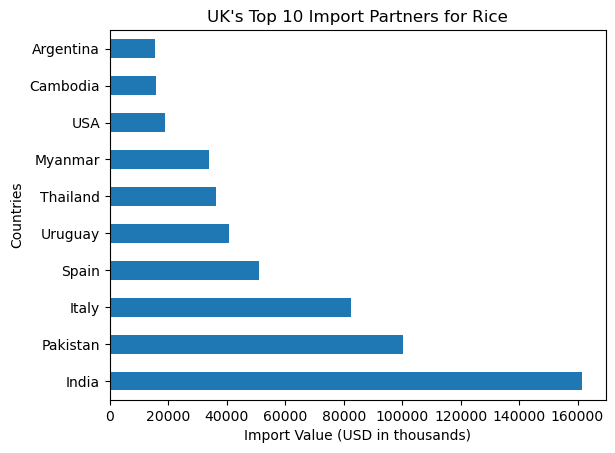

In [742]:
# Plot a bar chart
totalImports.head(10).plot(kind='barh')
plt.xlabel("Import Value (USD in thousands)")
plt.ylabel("Countries")
plt.title("UK's Top 10 Import Partners for Rice")
plt.show()

In [743]:
# Create a new DataFrame 'exports'
exports = rice[rice[FLOW] == 'Export']
# Group the 'exports' dataframe by the 'PARTNER' column
grouped = exports.groupby([PARTNER])
print('The UK exports to', len(grouped), 'countries.')
print('The 5 biggest importers from the UK are:')
# Calculate the total exports from each country, sort them in descending order, and round the values to thousands
totalExports = grouped[VALUE].aggregate(sum).sort_values(ascending=False,inplace=False).apply(roundToThousands)
totalExports.head(10)

The UK exports to 66 countries.
The 5 biggest importers from the UK are:


PartnerDesc
Ireland        13161
Netherlands    12082
France         11577
Germany         4919
Areas, nes      3327
Italy           2746
Belgium         1640
Malta            860
Sweden           833
Iceland          818
Name: PrimaryValue, dtype: int64

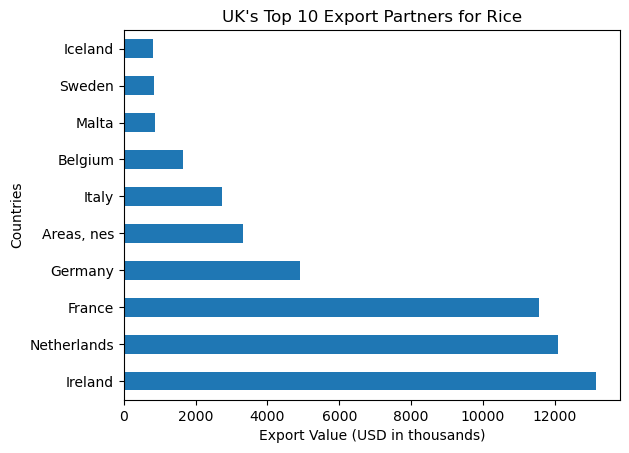

In [744]:
# Plot a bar chart
totalExports.head(10).plot(kind='barh')
plt.xlabel("Export Value (USD in thousands)")
plt.ylabel("Countries")
plt.title("UK's Top 10 Export Partners for Rice")
plt.show()

Out of my curiosity, I would like to investigate whether there are any seasonal trends in import behavior, with a focus on the major rice types of 'milled' and 'brown'.

In [745]:
# Filter the 'imports' DataFrame to select rows where the 'COMMODITY' column is 'milled'/'brown'
milled = imports[imports[COMMODITY]== 'milled']
brown = imports[imports[COMMODITY]== 'brown']

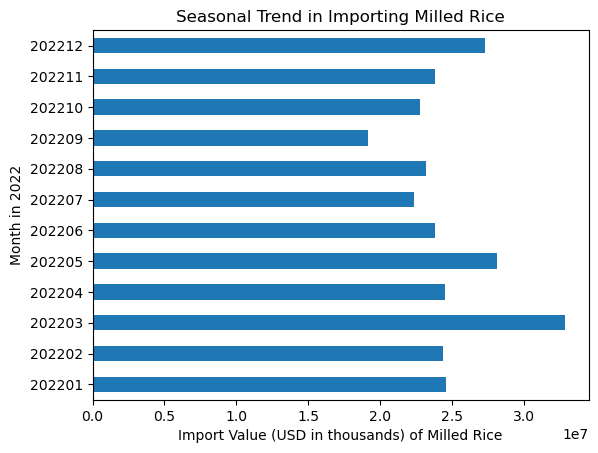

In [746]:
# Group the data in the 'milled' DataFrame by the 'MONTH' column and calculate the sum of the 'VALUE' column for each month
milled.groupby([MONTH])[VALUE].aggregate(sum).plot(kind='barh')
plt.xlabel("Import Value (USD in thousands) of Milled Rice")
plt.ylabel("Month in 2022")
plt.title("Seasonal Trend in Importing Milled Rice")
plt.show()

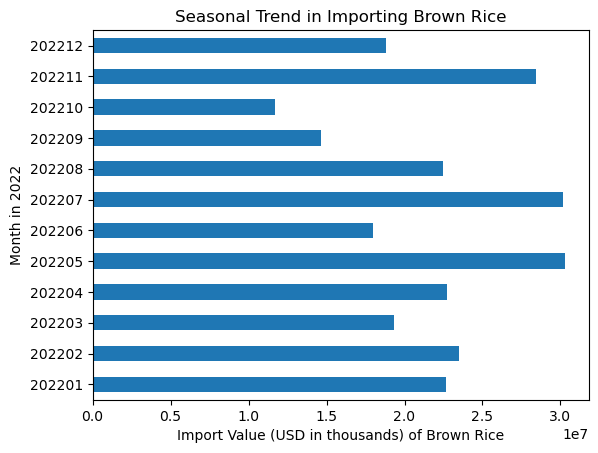

In [747]:
# Group the data in the 'brown' DataFrame by the 'MONTH' column and calculate the sum of the 'VALUE' column for each month
brown.groupby([MONTH])[VALUE].aggregate(sum).plot(kind='barh')
plt.xlabel("Import Value (USD in thousands) of Brown Rice")
plt.ylabel("Month in 2022")
plt.title("Seasonal Trend in Importing Brown Rice")
plt.show()

For milled rice, the largest single monthly trade flow in 2022 appears to have occurred in March (202203), and the weakest month was September (202209). For brown rice, May and July saw the highest import values, while October had the weakest import values. There appears to be a trend of decreasing import values around September and October for both milled and brown rice. 

## Regular partners

Let us return to the third question, "Which are the regular customers, i.e. which countries buy rice from the UK and sell to the UK every month?" Here, a "regular customer" is meant to indicate a country that imports both commodities every month.

To identify these countries, we can group the import/exports dataframe by country. Import and export data would need to have more than 24 and 12 rows, since there were two and one major kinds of rice (milled and brown or milled only) recorded each month over the course of a year (12 months) respectively.

To see the countries that qualify as regular customers, it would suffice to list only the first month's data for one commodity - as by our definition, the same countries would appear month-over-month and for the other commodity type as well.

In [748]:
# Define a function that takes a group as input
def buysEveryMonth(group):
    # Check if the length of the group is greater than or equal to 24
    return len(group) >= 24

grouped = imports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular.sort_values(VALUE, ascending=False).head(5)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
807,202207,India,Import,brown,2.061330e+07
1322,202211,India,Import,brown,1.961395e+07
1444,202212,India,Import,brown,1.205263e+07
399,202204,Pakistan,Import,brown,1.038058e+07
290,202203,Italy,Import,milled,9.665562e+06


In [749]:
regularImpJan = regular[(regular[MONTH] == 202201)].sort_values(VALUE, ascending=False)
regularImpJan.head(5)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
20,202201,India,Import,brown,9074246.633
17,202201,Pakistan,Import,brown,7448017.350
52,202201,India,Import,milled,6781056.724
62,202201,Myanmar,Import,broken,6234314.231
41,202201,Italy,Import,milled,6112582.889


In [750]:
regular[VALUE].sum() / imports[VALUE].sum()

0.7931005161946342

In [751]:
# Define a function that takes a group as input
def buysEveryMonth(group):
    # Check if the length of the group is greater than or equal to 12
    return len(group) >= 12

grouped = exports.groupby([PARTNER])
regular = grouped.filter(buysEveryMonth)
regular.sort_values(VALUE, ascending=False).head(5)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
1522,202212,France,Export,milled,1937978.741
482,202204,Ireland,Export,milled,1595044.684
1397,202211,France,Export,milled,1589510.211
1403,202211,Ireland,Export,milled,1450030.134
1527,202212,Ireland,Export,milled,1401032.365


In [752]:
regularExpJan = regular[(regular[MONTH] == 202201)].sort_values(VALUE, ascending=False)
regularExpJan.head(5)

,Period,PartnerDesc,FlowDesc,RiceType,PrimaryValue
102,202201,Ireland,Export,milled,556886.546
97,202201,France,Export,milled,485008.455
106,202201,Netherlands,Export,milled,372155.869
98,202201,Germany,Export,milled,103778.753
94,202201,Cyprus,Export,milled,94593.833


In [753]:
regular[VALUE].sum() / exports[VALUE].sum()

0.9696625283516452

For rice imports, the UK's regular trade partners are located in South Asia and Southeast Asia, including India, Pakistan, and Myanmar. Italy is also a major import partner from Europe. Together, these countries account for 79.3% of total UK rice imports.

Regarding rice exports, the UK's regular trade partners are European countries such as Ireland, France, the Netherlands, and Germany. These recurring customers comprise around 96.9% of total UK rice exports.

## Bi-directional trade

To address the fourth question, 
'Which countries does the UK both import from and export to?', a pivot table is used to list the total export and import value for each country. 

In [754]:
countries = pd.pivot_table(rice, index=[PARTNER], columns=[FLOW], values=VALUE, aggfunc=sum)
countries.head()

FlowDesc,Export,Import
PartnerDesc,,
Antarctica,17417.400,NaN
"Areas, nes",3326775.751,NaN
Argentina,11808.178,1.553813e+07
Australia,161640.196,2.879119e+06
Austria,154112.827,2.075998e+03


Removing the rows with a missing value will result in only those countries with bi-directional trade flow with the UK.

In [755]:
countries = countries.dropna().apply(roundToThousands)
# Reset the pivot table to a regular DataFrame
countries = countries.reset_index()
countries

FlowDesc,PartnerDesc,Export,Import
0,Argentina,12.0,15538.0
1,Australia,162.0,2879.0
2,Austria,154.0,2.0
3,Bangladesh,0.0,688.0
4,Belgium,1640.0,1843.0
5,Bulgaria,6.0,162.0
6,Cambodia,0.0,15703.0
7,"China, Hong Kong SAR",73.0,113.0
8,Egypt,9.0,7.0
9,France,11577.0,1118.0


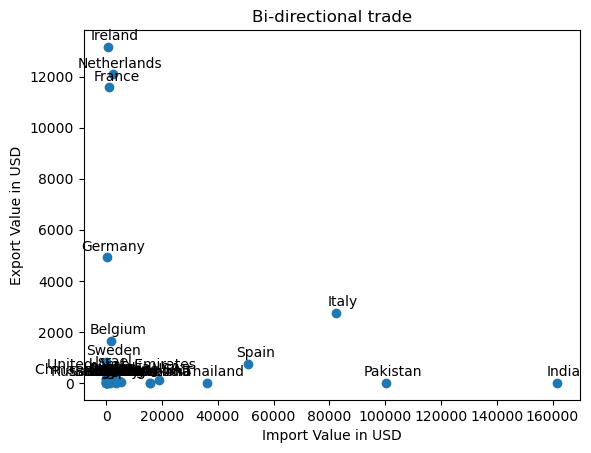

In [756]:

# Create the scatter plot
plt.scatter(countries['Import'], countries['Export'])

# Add nation names as annotations near the dots
for i, (x, y, country) in enumerate(zip(countries['Import'], countries['Export'], countries['PartnerDesc'])):
    plt.annotate(country, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Set labels and title
plt.xlabel("Import Value in USD")
plt.ylabel("Export Value in USD")
plt.title("Bi-directional trade")

# Show the plot
plt.show()

It appears the UK engages in bi-directional rice trade with 32 countries, although some of the values are quite low. As shown on the scatter plot, the UK both imports and exports a certain volume of rice to and from Italy, making it the country with the strongest two-way trade according to the available data. 

## Conclusions

- The rice trade of the UK from January to December 2022 was analyzed in terms of which countries the UK most relies upon for income (exports) and goods (imports). Over this period, the UK had a rice trade deficit exceeding 550 thousand US dollars.

- The UK regularly imports rice from South and Southeast Asian countries such as India, Pakistan, and Myanmar, with Italy serving as the most influential partner in Europe.

- While rice exports are not as substantial as imports, the UK's primary export partners are located in Europe, including Ireland, France, the Netherlands, and Germany.

- Domestically, the UK depends heavily on its consistent trade partners, as they account for more than 80% of total export value.

- Bilateral rice trade was identified with 32 countries, though some values (in US dollars) were suspiciously low, warranting scrutiny of the data accuracy.

- These insights are limited by analyzing only 2022 data, which included missing values and questionable figures. A longitudinal study examining multi-year trade patterns could provide a more robust interpretation, particularly regarding impacts from events like the COVID-19 pandemic before and after 2019.